# This test doesn't use any labels at all, but evaluates models on their user assessed false positive and false negative rates after predictions are made. 
1. Make predictions on a recording
2. look at the model predictions sorted by confidence. 
3. Count the false positives and false negatives within these predictions. 

In [1]:
# imports
from pathlib import Path
import sys
import shutil
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
model_save_path = BASE_PATH / 'models'
import pandas as pd
import numpy as np
import opensoundscape as opso
from opensoundscape import audio
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from ipywidgets import interact
import glob
from src.utils import  show_samples_in_df, get_binary_targets_scores, suppress_warnings_if_main_branch, plot_metrics_across_thresholds, hawkears_files_to_df, plot_confusion_matrix, save_dataframe_clips_to_disk, show_sample_from_df, show_clip_from_multi_index_df, inspect_wrong_predictions, top_down_listen

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# load the test data
data_path = Path.cwd().parent.parent / "data"
test_df = pd.read_pickle(data_path / "interim" / "test_set" / "test_set.pkl")
ext_df = pd.read_csv(data_path / "raw" / "test_set" / "SingleSpecies_all.csv", low_memory=False)

In [3]:
# Load the target species examples from the external test set
ext_df = pd.read_csv(data_path / "raw" / "test_set" / "SingleSpecies_all.csv", low_memory=False)
# filter out all the other species
osfls = ext_df.loc[ext_df.species_code == "OSFL"]
# filter out the target species calls and keep the songs. 
osfls = osfls.loc[osfls.vocalization == "Song"]

In [4]:
recording_save_path = data_path / "raw" / "recordings" / "OSFL"
external_test_set_recordings = data_path / "processed" / "external_test_set_recordings"

def get_file_extension(url):
    file_type = url.split('.')[-1]
    return file_type
def make_filename(df):
    
    return f"recording-{df.recording_id}.{df.file_type}"

osfls['file_type'] = osfls['recording_url'].apply(get_file_extension)
osfls['filename'] = osfls.apply(make_filename, axis=1)
external_test_set_filenames = osfls.filename.unique()
len(external_test_set_filenames), external_test_set_filenames

(39,
 array(['recording-255472.flac', 'recording-255412.mp3',
        'recording-255913.flac', 'recording-255938.flac',
        'recording-255940.flac', 'recording-255949.flac',
        'recording-255967.flac', 'recording-255980.flac',
        'recording-255420.mp3', 'recording-255419.mp3',
        'recording-255421.mp3', 'recording-255431.mp3',
        'recording-255432.mp3', 'recording-255433.mp3',
        'recording-255449.mp3', 'recording-255456.mp3',
        'recording-255454.mp3', 'recording-255457.mp3',
        'recording-255461.mp3', 'recording-255465.mp3',
        'recording-255539.flac', 'recording-255544.flac',
        'recording-255497.mp3', 'recording-255513.mp3',
        'recording-255518.mp3', 'recording-255526.mp3',
        'recording-255623.flac', 'recording-255624.flac',
        'recording-255625.flac', 'recording-255580.mp3',
        'recording-255581.mp3', 'recording-255582.mp3',
        'recording-255649.flac', 'recording-255607.mp3',
        'recording-255665.mp3'

In [5]:
# if the recordings are not already saved, save them to the processed folder
if not external_test_set_recordings.exists():
    external_test_set_recordings.mkdir(parents=True, exist_ok=True)
    for file in external_test_set_filenames:
        source = recording_save_path / file
        destination = external_test_set_recordings / file
        shutil.copy(source, destination)
        print(f"copied {source} to {destination}")
else:
    print(f"Recordings already saved to {external_test_set_recordings}")
        

Recordings already saved to /Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/external_test_set_recordings


# The model was run using the predict.py program in the OSFL project root.

# Processing times

39 recordings, 782.2mb <br>
Took 11 min 31 seconds to process with OSFL recognizer on 1 CPU core on mac<br>
Another time it took 8 minutes<br>
took 17 mins on windows machine with 1 cpu core, and this decreased to 13 mins with 8 cores



# Load the OSFL model predictions

In [8]:
osfl_model_predictions = pd.read_csv(BASE_PATH / "OSFL-scores.csv").sort_values(by="target_present", ascending=False)

<Axes: >

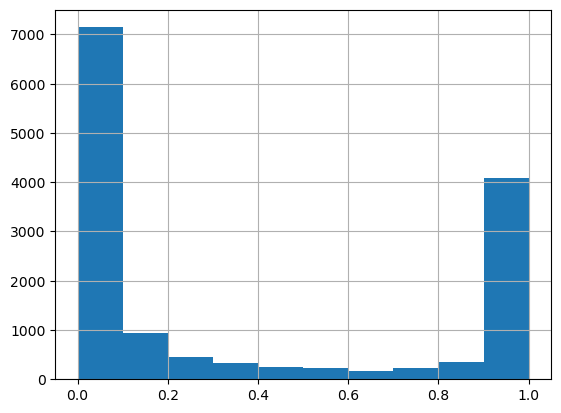

In [9]:
# change the name of the target present column to predictions
osfl_model_predictions = osfl_model_predictions.rename(columns={"target_present": "predicted"})
osfl_model_predictions.predicted.hist()

In [10]:
osfl_model_predictions.head()

,file,start_time,end_time,predicted
3093,data/processed/external_test_set_recordings/re...,459.0,462.0,0.999997
3112,data/processed/external_test_set_recordings/re...,487.5,490.5,0.999996
8885,data/processed/external_test_set_recordings/re...,175.5,178.5,0.999995
3020,data/processed/external_test_set_recordings/re...,349.5,352.5,0.999995
3167,data/processed/external_test_set_recordings/re...,570.0,573.0,0.999994


# Load the hawkears preds

# Merge the data from OSFL.model and hawkears

In [11]:
def get_rec_id_from_index(file_path):
    return file_path.split("/")[-1].split("-")[1].split(".")[0]
osfl_model_predictions['file_id'] = osfl_model_predictions.index.get_level_values('file').map(get_rec_id_from_index)

KeyError: 'Requested level (file) does not match index name (None)'

The amount of validation effort required to process these top 4000 + confident predictions would be around 20 hours. I'm taking a sample of the recordings to work on instead. 

In [220]:
osfl_model_predictions.set_index(["file", "start_time", "end_time"], inplace=True)

In [557]:
osfl_model_predictions_reset = osfl_model_predictions.reset_index()
osfl_model_predictions_reset

,file,start_time,end_time,predicted,file_id
0,/Users/mikeg/code/machine_learning/osfl_cnn_re...,459.0,462.0,0.999997,255625
1,/Users/mikeg/code/machine_learning/osfl_cnn_re...,487.5,490.5,0.999996,255625
2,/Users/mikeg/code/machine_learning/osfl_cnn_re...,175.5,178.5,0.999995,255454
3,/Users/mikeg/code/machine_learning/osfl_cnn_re...,349.5,352.5,0.999995,255625
4,/Users/mikeg/code/machine_learning/osfl_cnn_re...,570.0,573.0,0.999994,255625
...,...,...,...,...,...
14187,/Users/mikeg/code/machine_learning/osfl_cnn_re...,123.0,126.0,0.000297,255421
14188,/Users/mikeg/code/machine_learning/osfl_cnn_re...,133.5,136.5,0.000287,255949
14189,/Users/mikeg/code/machine_learning/osfl_cnn_re...,108.0,111.0,0.000237,255421
14190,/Users/mikeg/code/machine_learning/osfl_cnn_re...,124.5,127.5,0.000200,255421


In [567]:
df.start_time = df.start_time.astype(float)
df.end_time = df.end_time.astype(float)
osfl_model_predictions_reset.start_time = osfl_model_predictions_reset.start_time.astype(float)
osfl_model_predictions_reset.end_time = osfl_model_predictions_reset.end_time.astype(float)


In [572]:
merged_df = pd.merge(osfl_model_predictions_reset, df, on=["file_id", "start_time", "end_time"],suffixes=('_df1', '_df2'))
df

,file_id,start_time,end_time,species;confidence
0,256053,0.0,3.0,ACFL;0.01
1,256053,1.5,4.5,ACFL;0.01
2,256053,3.0,6.0,ACFL;0.01
3,256053,4.5,7.5,ACFL;0.01
4,256053,6.0,9.0,ACFL;0.01
...,...,...,...,...
4350397,256035,591.0,594.0,YTWA;0.01
4350398,256035,592.5,595.5,YTWA;0.01
4350399,256035,594.0,597.0,YTWA;0.01
4350400,256035,595.5,598.5,YTWA;0.01


# Choose a sample of the recordings which isn't going to take too long to get through


<Axes: >

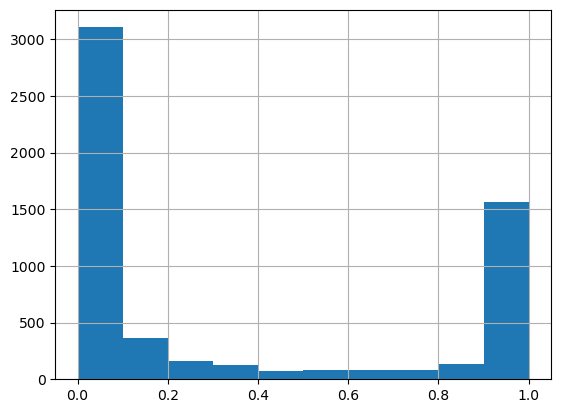

In [573]:
recordings = osfl_model_predictions.index.get_level_values("file").unique()
sample = np.random.choice(recordings, 15)

osfl_model_predictions.loc[sample].predicted.hist()

# Top down listening


('/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/data/processed/external_test_set_recordings/recording-255625.flac', 459.0, 462.0)
prediction = 0.9999975


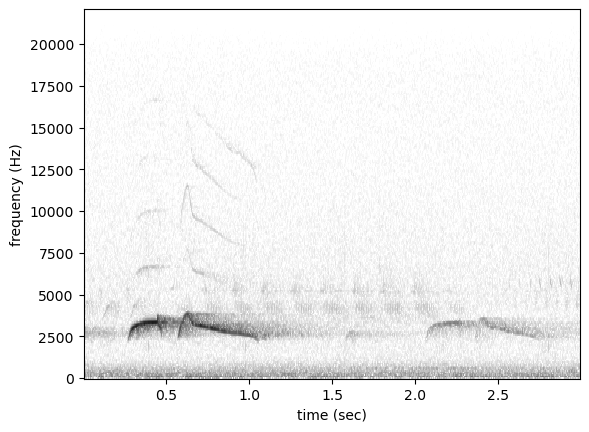

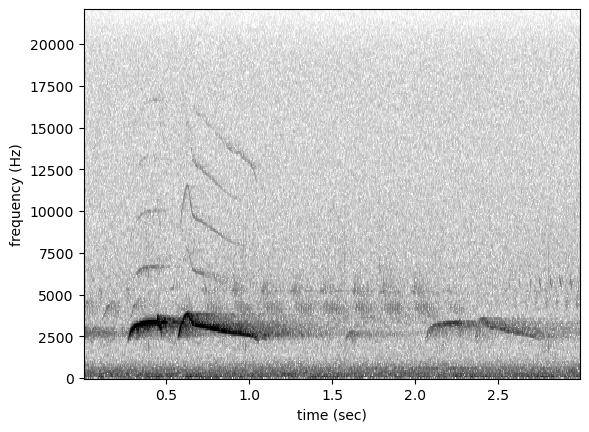

top down listening mode: press enter to autolabel as present or 2 for absent
added confidence tag 1 to the dataframe.
verification counts for all clips
confidence_cat
0    14191
1        1
Name: count, dtype: int64


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:474: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, "confidence_cat"] = int(user_confidence)


predicted  \
file                                               start_time end_time              
/Users/mikeg/code/machine_learning/osfl_cnn_rec... 459.0      462.0      0.999997   
                                                   487.5      490.5      0.999996   
/Users/mikeg/code/machine_learning/osfl_cnn_rec... 175.5      178.5      0.999995   
/Users/mikeg/code/machine_learning/osfl_cnn_rec... 349.5      352.5      0.999995   
                                                   570.0      573.0      0.999994   
...                                                                           ...   
/Users/mikeg/code/machine_learning/osfl_cnn_rec... 123.0      126.0      0.000297   
/Users/mikeg/code/machine_learning/osfl_cnn_rec... 133.5      136.5      0.000287   
/Users/mikeg/code/machine_learning/osfl_cnn_rec... 108.0      111.0      0.000237   
                                                   124.5      127.5      0.000200   
                                                   130.5      133.5      0.000182   

                                                                       file_id  \
file                                               start_time end_time           
/Users/mikeg/code/machine_learning/osfl_cnn_rec... 459.0      462.0     255625   
                                                   487.5      490.5     255625   
/Users/mikeg/code/machine_learning/osfl_cnn_rec... 175.5      178.5     255454   
/Users/mikeg/code/machine_learning/osfl_cnn_rec... 349.5      352.5     255625   
                                                   570.0      573.0     255625   
...                                                                        ...   
/Users/mikeg/code/machine_learning/osfl_cnn_rec... 123.0      126.0     255421   
/Users/mikeg/code/machine_learning/osfl_cnn_rec... 133.5      136.5     255949   
/Users/mikeg/code/machine_learning/osfl_cnn_rec... 108.0      111.0     255421   
                                                   124.5      127.5     255421   
                                                   130.5      133.5     255421   

                                                                        confidence_cat  
file                                               start_time end_time                  
/Users/mikeg/code/machine_learning/osfl_cnn_rec... 459.0      462.0                  1  
                                                   487.5      490.5                  0  
/Users/mikeg/code/machine_learning/osfl_cnn_rec... 175.5      178.5                  0  
/Users/mikeg/code/machine_learning/osfl_cnn_rec... 349.5      352.5                  0  
                                                   570.0      573.0                  0  
...                                                                                ...  
/Users/mikeg/code/machine_learning/osfl_cnn_rec... 123.0      126.0                  0  
/Users/mikeg/code/machine_learning/osfl_cnn_rec... 133.5      136.5                  0  
/Users/mikeg/code/machine_learning/osfl_cnn_rec... 108.0      111.0                  0  
                                                   124.5      127.5                  0  
                                                   130.5      133.5                  0  

[14192 rows x 3 columns]

In [575]:
def reset_confidence_cats():
    osfl_model_predictions["confidence_cat"] = 0
reset_confidence_cats()

top_down_listen(osfl_model_predictions)